In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36011 
    Total predicted counts          : 35742.68
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.94 s, sys: 15.8 ms, total: 2.96 s
Wall time: 2.97 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 36169 
    Total predicted counts          : 35806.08
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 35665 
    Total predicted counts          : 35869.68
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_14 

    Total counts                    : 36043 
    Total predicted counts          : 35830.48
    Total off counts                : 101796.00

    Total background counts         : 20359.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_15 

    Total counts                    : 35396 
    Total predicted counts          : 35757.88
    Total off counts                : 101433.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 36175 
    Total predicted counts          : 35714.88
    Total off counts                : 101218.00

    Total background counts         : 20243.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 35557 
    Total predicted counts          : 35669.08
    Total off counts                : 100989.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_49 

    Total counts                    : 36014 
    Total predicted counts          : 35856.08
    Total off counts                : 101924.00

    Total background counts         : 20384.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_50 

    Total counts                    : 35667 
    Total predicted counts          : 35801.28
    Total off counts                : 101650.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_70 

    Total counts                    : 35794 
    Total predicted counts          : 35777.08
    Total off counts                : 101529.00

    Total background counts         : 20305.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_71 

    Total counts                    : 35833 
    Total predicted counts          : 35724.28
    Total off counts                : 101265.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_88 

    Total counts                    : 35651 
    Total predicted counts          : 35739.48
    Total off counts                : 101341.00

    Total background counts         : 20268.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 35803 
    Total predicted counts          : 35715.28
    Total off counts                : 101220.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_109 

    Total counts                    : 35724 
    Total predicted counts          : 35828.28
    Total off counts                : 101785.00

    Total background counts         : 20357.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_110 

    Total counts                    : 35816 
    Total predicted counts          : 35825.68
    Total off counts                : 101772.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_128 

    Total counts                    : 35750 
    Total predicted counts          : 35776.68
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_129 

    Total counts                    : 35729 
    Total predicted counts          : 35772.08
    Total off counts                : 101504.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 35424 
    Total predicted counts          : 35850.88
    Total off counts                : 101898.00

    Total background counts         : 20379.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_148 

    Total counts                    : 35717 
    Total predicted counts          : 35849.68
    Total off counts                : 101892.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_164 

    Total counts                    : 35708 
    Total predicted counts          : 35693.68
    Total off counts                : 101112.00

    Total background counts         : 20222.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_165 

    Total counts                    : 36068 
    Total predicted counts          : 35862.88
    Total off counts                : 101958.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_181 

    Total counts                    : 35705 
    Total predicted counts          : 35826.08
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_182 

    Total counts                    : 35485 
    Total predicted counts          : 35820.48
    Total off counts                : 101746.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 35459 
    Total predicted counts          : 35796.08
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 35661 
    Total predicted counts          : 35746.08
    Total off counts                : 101374.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_217 

    Total counts                    : 35418 
    Total predicted counts          : 35792.68
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_218 

    Total counts                    : 35888 
    Total predicted counts          : 35711.88
    Total off counts                : 101203.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_238 

    Total counts                    : 35676 
    Total predicted counts          : 35788.08
    Total off counts                : 101584.00

    Total background counts         : 20316.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_239 

    Total counts                    : 35900 
    Total predicted counts          : 35890.88
    Total off counts                : 102098.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 35794 
    Total predicted counts          : 35780.08
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_257 

    Total counts                    : 35873 
    Total predicted counts          : 35740.28
    Total off counts                : 101345.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_274 

    Total counts                    : 35739 
    Total predicted counts          : 35768.08
    Total off counts                : 101484.00

    Total background counts         : 20296.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_275 

    Total counts                    : 35541 
    Total predicted counts          : 35855.08
    Total off counts                : 101919.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_293 

    Total counts                    : 35924 
    Total predicted counts          : 35870.28
    Total off counts                : 101995.00

    Total background counts         : 20399.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_294 

    Total counts                    : 35745 
    Total predicted counts          : 35812.68
    Total off counts                : 101707.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 35815 
    Total predicted counts          : 35727.68
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_310 

    Total counts                    : 35635 
    Total predicted counts          : 35876.28
    Total off counts                : 102025.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 35309 
    Total predicted counts          : 35819.88
    Total off counts                : 101743.00

    Total background counts         : 20348.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_325 

    Total counts                    : 35963 
    Total predicted counts          : 35746.68
    Total off counts                : 101377.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_338 

    Total counts                    : 35803 
    Total predicted counts          : 35812.88
    Total off counts                : 101708.00

    Total background counts         : 20341.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_339 

    Total counts                    : 35236 
    Total predicted counts          : 35666.08
    Total off counts                : 100974.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_351 

    Total counts                    : 35658 
    Total predicted counts          : 35760.48
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_352 

    Total counts                    : 35939 
    Total predicted counts          : 35899.68
    Total off counts                : 102142.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_365 

    Total counts                    : 35794 
    Total predicted counts          : 35738.28
    Total off counts                : 101335.00

    Total background counts         : 20267.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_366 

    Total counts                    : 35771 
    Total predicted counts          : 35783.08
    Total off counts                : 101559.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 35613 
    Total predicted counts          : 35800.08
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_381 

    Total counts                    : 35940 
    Total predicted counts          : 35727.48
    Total off counts                : 101281.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 35588 
    Total predicted counts          : 35841.48
    Total off counts                : 101851.00

    Total background counts         : 20370.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 35767 
    Total predicted counts          : 35851.28
    Total off counts                : 101900.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 36070 
    Total predicted counts          : 35814.28
    Total off counts                : 101715.00

    Total background counts         : 20343.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_412 

    Total counts                    : 35880 
    Total predicted counts          : 35726.08
    Total off counts                : 101274.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_427 

    Total counts                    : 35868 
    Total predicted counts          : 35585.08
    Total off counts                : 100569.00

    Total background counts         : 20113.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_428 

    Total counts                    : 35741 
    Total predicted counts          : 35835.28
    Total off counts                : 101820.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_443 

    Total counts                    : 35762 
    Total predicted counts          : 35825.68
    Total off counts                : 101772.00

    Total background counts         : 20354.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_444 

    Total counts                    : 35693 
    Total predicted counts          : 35975.68
    Total off counts                : 102522.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_457 

    Total counts                    : 36039 
    Total predicted counts          : 35767.88
    Total off counts                : 101483.00

    Total background counts         : 20296.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_458 

    Total counts                    : 36163 
    Total predicted counts          : 35742.28
    Total off counts                : 101355.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 35649 
    Total predicted counts          : 35779.28
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 35929 
    Total predicted counts          : 35703.48
    Total off counts                : 101161.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 35670 
    Total predicted counts          : 35801.88
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_487 

    Total counts                    : 35616 
    Total predicted counts          : 35827.08
    Total off counts                : 101779.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

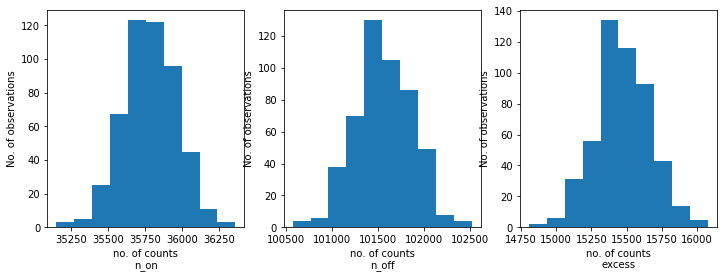

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 48s, sys: 315 ms, total: 1min 48s
Wall time: 1min 48s


In [15]:
results

[{'index': 2.2004131615267624,
  'amplitude': 1.3601486067384558e-12,
  'lambda_': 0.11118392218485627},
 {'index': 2.2186923632409274,
  'amplitude': 1.2740701906278792e-12,
  'lambda_': 0.10355633713292395},
 {'index': 2.2290865097653043,
  'amplitude': 1.2670462380582257e-12,
  'lambda_': 0.10267001537485579},
 {'index': 2.2298212935591573,
  'amplitude': 1.2642889222463049e-12,
  'lambda_': 0.09787260864958808},
 {'index': 2.241520319762935,
  'amplitude': 1.2651277900312725e-12,
  'lambda_': 0.09371184556562533},
 {'index': 2.2227177951774024,
  'amplitude': 1.2632522229738968e-12,
  'lambda_': 0.10172702474076745},
 {'index': 2.2390108273914753,
  'amplitude': 1.2625407510442764e-12,
  'lambda_': 0.0887897117289828},
 {'index': 2.2069527000591647,
  'amplitude': 1.313681166093688e-12,
  'lambda_': 0.11202134541516798},
 {'index': 2.2096971321107435,
  'amplitude': 1.3047687699340683e-12,
  'lambda_': 0.10273424521500699},
 {'index': 2.22604016793442,
  'amplitude': 1.262676439480

index: 2.219842704584508 += 0.01348043647633226


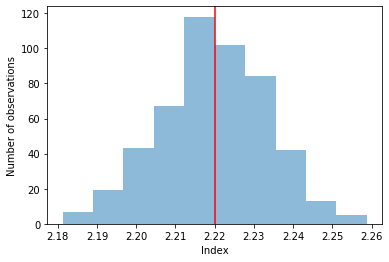

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2896437787842434e-12 += 3.018332627055102e-14


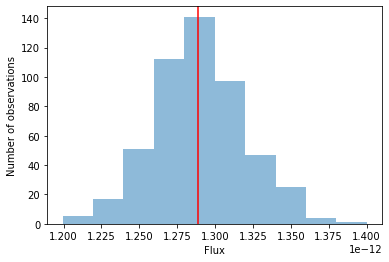

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.10046312364632183 += 0.009071331494553594


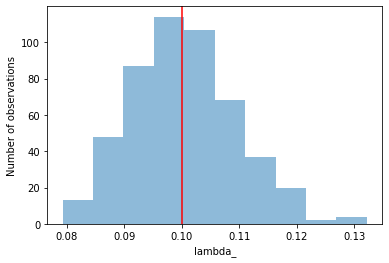

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")